In [1]:
import os
from scipy.misc import imread, imresize
import time
import random
import csv
import scipy.io as spio
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.contrib.rnn as rnn

%matplotlib inline

print("import 완료")
print ("TF VERSION %s" % (tf.__version__))

import 완료
TF VERSION 1.2.1


# Loading Data

In [2]:
tf.set_random_seed(180512)  

cwd = os.getcwd() # get current path

path = '/data/rotate,shift'

file_names = ['/train_input', '/train_output', '/test_input', '/test_output']
data_name = ['train_input', 'train_output', 'test_input', 'test_output']

data_type = 0
train_input = spio.loadmat(cwd + path + file_names[data_type])
train_input = np.array(train_input[data_name[data_type]], dtype = np.float32)

data_type = 1
train_output = spio.loadmat(cwd + path + file_names[data_type])
train_output = np.array(train_output[data_name[data_type]], dtype = np.float32)

data_type = 2
test_input = spio.loadmat(cwd + path + file_names[data_type])
test_input = np.array(test_input[data_name[data_type]], dtype = np.float32)

data_type = 3
test_output = spio.loadmat(cwd + path + file_names[data_type])
test_output = np.array(test_output[data_name[data_type]], dtype = np.float32)

# Shuffle train data

In [3]:
np.random.seed(201805012)
np.random.shuffle(train_input)

np.random.seed(201805012)
np.random.shuffle(train_output)

# Network Settings

In [4]:
# network options
learning_rate = 0.0001
batch_size = 5
training_epochs = 50

n_input = 784
n_step = 15
n_hidden = 256 # lstm's output
cell_num = 1 # Number of lstm layer

# data input settings
condition_num = 1 # (Autoencoder part) 1 is conditional decoder which recives the last generated output as input
condition_num_pred = 1 # (Predictor part) 1 is conditional decoder which recives the last generated output as input

reverse = 1 # 1 is Last in - First out
reverse_pred = 1 # 1 is Last in - First out

X = tf.placeholder(tf.float32, [None, n_step, n_input]) 
Y = tf.placeholder(tf.float32, [None, n_step, n_input]) 

# Autoencoder(encoder, decoder) and Predictor

In [5]:
def lstm_cell():
    cell = tf.nn.rnn_cell.BasicLSTMCell(n_hidden, activation = tf.nn.softsign)
    return cell

with tf.variable_scope('encoder'):
    enc_cell = tf.nn.rnn_cell.MultiRNNCell([lstm_cell() for _ in range(cell_num)], state_is_tuple=True)
    enc_outputs, enc_states = tf.nn.dynamic_rnn(enc_cell, X, dtype=tf.float32, scope ='encoder_part')
    
with tf.variable_scope('decoder'):
    dec_cell= tf.nn.rnn_cell.MultiRNNCell([lstm_cell() for _ in range(cell_num)], state_is_tuple=True)
    
    if condition_num == 0:
        print('Train decoder using zero input')
        
        dec_zero = tf.zeros(tf.shape(X), dtype = tf.float32)
        dec_outputs, dec_states = tf.nn.dynamic_rnn(dec_cell, dec_zero,initial_state = enc_states, dtype=tf.float32, scope ='decoder_part')
        
        if reverse == 1:
            dec_outputs = tf.reverse(dec_outputs, axis=[1]) # reverse figure sequence for each mini batch
            dec_outputs = tf.layers.dense(inputs = dec_outputs, units = n_input, activation = None) # shape(batch_size, n_step, n_input)
        
    else:
        print('Train decoder using previous output as input')
        
        dec_states = enc_states
        dec_inputs = tf.zeros([tf.shape(X)[0],n_input], dtype = tf.float32) # First input in decoder is zero, shape(batch_size, n_input)

        dec_outputs = []
        
        for i in range(n_step):
            _dec_inputs, dec_states = dec_cell(dec_inputs, dec_states)
            
            # dec_inputs can be current output and next output
            # First input shape is [batch_size, n_input] but _dec_inputs(output) have shape(batch_size, n_hidden)
            # Next input's shape must be shape(batch_size, n_input) => why we use tf.layers.dense
            # _dec_inputs(batch_size, n_hidden) => dec_inputs(batch_size, n_input)
            dec_inputs = tf.layers.dense(inputs =  _dec_inputs, units = n_input, activation = None) 
            dec_outputs.append(dec_inputs) # shape(n_step, batch_size, n_input)
        dec_outputs = tf.transpose(dec_outputs, [1, 0, 2]) # shape(batch_size, n_step, n_input)
       
    dec_outputs = tf.reverse(dec_outputs, axis=[1])
    
with tf.variable_scope('predictor'):
    pred_cell= tf.nn.rnn_cell.MultiRNNCell([lstm_cell() for _ in range(cell_num)], state_is_tuple=True)
    
    if condition_num_pred == 0:
        print('Train predictor using zero input')
        pred_zero = tf.zeros(tf.shape(X), dtype = tf.float32)
        pred_outputs, pred_states = tf.nn.dynamic_rnn(pred_cell, pred_zero,initial_state = enc_states, dtype=tf.float32, scope ='predictor_part')
        
        if reverse == 1:
            pred_outputs = tf.reverse(pred_outputs, axis=[1]) 
            pred_outputs = tf.layers.dense(inputs = pred_outputs, units = n_input, activation = None) 
        
    else:
        print('Train predictor using previous output as input')
 
        pred_states = enc_states
        pred_inputs = tf.zeros([tf.shape(X)[0],n_input], dtype = tf.float32) # firtst input in decoder is zero

        pred_outputs = []
        
        for i in range(n_step):
            _pred_inputs, pred_states = dec_cell(pred_inputs, pred_states)
            
            
            pred_inputs = tf.layers.dense(inputs =  _pred_inputs, units = n_input, activation = None) 
            pred_outputs.append(pred_inputs)
        pred_outputs = tf.transpose(pred_outputs, [1, 0, 2])
        
    pred_outputs = tf.reverse(pred_outputs, axis=[1])


Train decoder using previous output as input
Train predictor using previous output as input


In [6]:
dec_cost = tf.reduce_mean(tf.pow(X  - dec_outputs,2))
pred_cost = tf.reduce_mean(tf.pow(Y  - pred_outputs,2))

dec_optimizer = tf.train.RMSPropOptimizer(learning_rate=learning_rate).minimize(dec_cost)
pred_optimizer = tf.train.RMSPropOptimizer(learning_rate=learning_rate).minimize(pred_cost)

total_cost = dec_cost + pred_cost

In [7]:
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

# Train

In [8]:
start_time = time.time()
for epoch in range(training_epochs):
    avg_cost = 0
    total_batch =  len(train_input)
    for i in range(int(total_batch/batch_size)):

        batch_xs = train_input[i*batch_size:(i+1)*batch_size]
        batch_xs = np.reshape(batch_xs, [batch_size, n_step, n_input])
        
        batch_ys = train_output[i*batch_size:(i+1)*batch_size]
        batch_ys = np.reshape(batch_ys, [batch_size, n_step, n_input])
        feed_dict = {X: batch_xs, Y: batch_ys}
        
        c, _, _ = sess.run([total_cost, dec_optimizer, pred_optimizer], feed_dict=feed_dict)
        avg_cost += c / total_batch
    print('\rEpoch:', '%04d' % (epoch + 1), 'cost =', '{:.9f}'.format(avg_cost), end = '')

end_time = time.time()
print('\nTime taken : {}s'.format(end_time - start_time))

Epoch: 0050 cost = 0.006265695
Time taken : 858.0920000076294s


# Show the result to use train input(Above:Reconstructed, Below:Original)

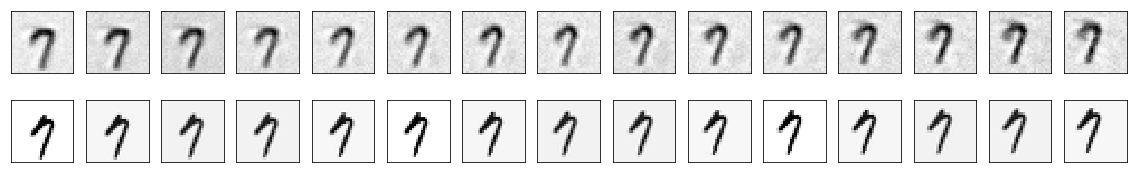

In [11]:
figure_num = 3 
feed_dict = {X: train_input}
results = sess.run(dec_outputs, feed_dict = feed_dict)


fig1= plt.figure(figsize=(20,3))
for i in range(15):
    
    snap = fig1.add_subplot(2, 15, i+1)
    plt.imshow(results[figure_num,i].reshape([28, 28]), cmap = 'Greys')
    snap.set_xticks([])
    snap.set_yticks([])
    
    snap = fig1.add_subplot(2, 15, i+16)
    plt.imshow(train_input[figure_num,i].reshape([28, 28]), cmap = 'Greys')
    
    snap.set_xticks([])
    snap.set_yticks([])
plt.show()

# Show the result to use test input(Above:Reconstructed, Below:Original)

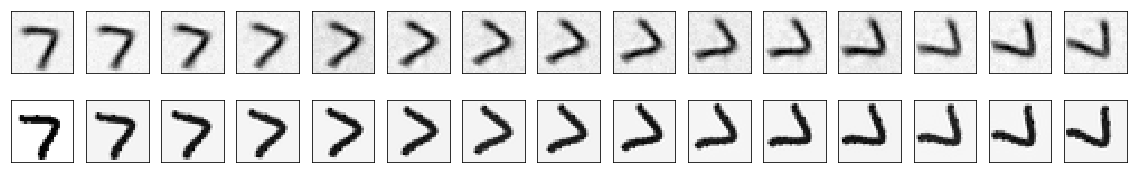

In [12]:
feed_dict = {X: test_input}
results = sess.run(dec_outputs, feed_dict = feed_dict)

fig2= plt.figure(figsize=(20,3))
for i in range(15):
    
    snap = fig2.add_subplot(2, 15, i+1)
    plt.imshow(results[figure_num,i].reshape([28, 28]), cmap = 'Greys')
    snap.set_xticks([])
    snap.set_yticks([])
        
    snap = fig2.add_subplot(2, 15, i+16)
    plt.imshow(test_input[figure_num,i].reshape([28, 28]), cmap = 'Greys')
    
    snap.set_xticks([])
    snap.set_yticks([])
plt.show()

# Show the result to use train input(Above:Predicted, Below:Original)

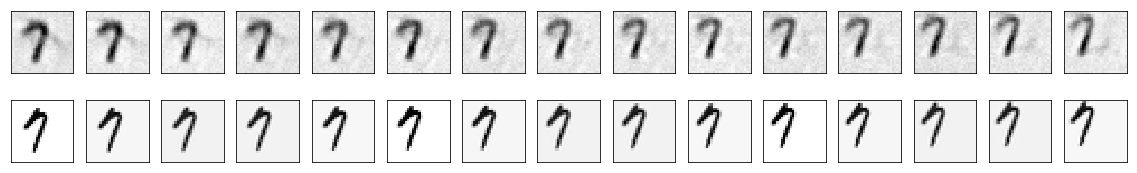

In [14]:
feed_dict = {X: train_input}
results = sess.run(pred_outputs, feed_dict = feed_dict)


fig3= plt.figure(figsize=(20,3))
for i in range(15):
    
    snap = fig3.add_subplot(2, 15, i+1)
    plt.imshow(results[figure_num,i].reshape([28, 28]), cmap = 'Greys')
    snap.set_xticks([])
    snap.set_yticks([])

    
    snap = fig3.add_subplot(2, 15, i+16)
    plt.imshow(train_output[figure_num,i].reshape([28, 28]), cmap = 'Greys')
    
    snap.set_xticks([])
    snap.set_yticks([])
plt.show()

# Show the result to use test input(Above:Predicted, Below:Original)

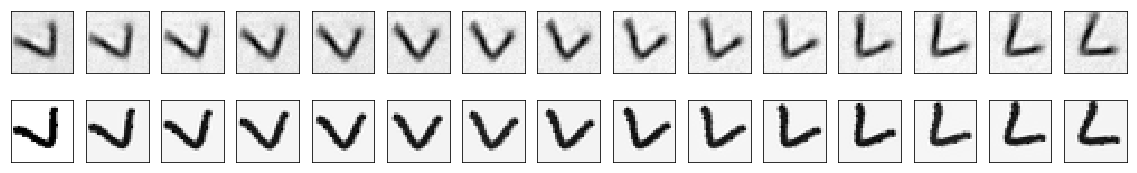

In [15]:

feed_dict = {X: test_input}
results = sess.run(pred_outputs, feed_dict = feed_dict)


fig4 = plt.figure(figsize=(20,3))
for i in range(15):
    
    snap = fig4.add_subplot(2, 15, i+1)
    plt.imshow(results[figure_num,i].reshape([28, 28]), cmap = 'Greys')
    snap.set_xticks([])
    snap.set_yticks([])
    
    snap = fig4.add_subplot(2, 15, i+16)
    plt.imshow(test_output[figure_num,i].reshape([28, 28]), cmap = 'Greys')
    
    snap.set_xticks([])
    snap.set_yticks([])
plt.show()